In [2]:
import json

from util.datasets import build_chr_transform
import models_vit
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, multilabel_confusion_matrix, confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, f1_score, matthews_corrcoef
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, matthews_corrcoef
)
from math import sqrt
from pycm import ConfusionMatrix
from tqdm import tqdm 
import seaborn as sns
from matplotlib.colors import LogNorm
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import binom
from scipy.optimize import brentq
import math
from math import pi

import os
from torchvision import datasets, transforms

from PIL import Image
import cv2
import timm
import json
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget


In [163]:
results_baseline_conv = np.load('./paper_fig_unstadis_data/res_baseline_conv.npy', allow_pickle=True).item()
results_baseline_vit = np.load('./paper_fig_unstadis_data/res_baseline_vit.npy', allow_pickle=True).item()
results_baseline_ssl_cl = np.load('./paper_fig_unstadis_data/res_baseline_ssl_cl.npy', allow_pickle=True).item()
results_baseline_ssl_mae = np.load('./paper_fig_unstadis_data/res_baseline_ssl_mae.npy', allow_pickle=True).item()
results_chroma = np.load('./paper_fig_unstadis_data/res_chroma.npy', allow_pickle=True).item()

print(results_baseline_conv[2]['seed_0']['auc_roc'])
print(results_baseline_vit[2]['seed_0']['auc_roc'])
print(results_baseline_ssl_cl[2]['seed_0']['auc_roc'])
print(results_baseline_ssl_mae[2]['seed_0']['auc_roc'])
print(results_chroma[2]['seed_0']['auc_roc'])

print(results_baseline_conv[5]['seed_0']['auc_roc'])
print(results_baseline_vit[5]['seed_0']['auc_roc'])
print(results_baseline_ssl_cl[5]['seed_0']['auc_roc'])
print(results_baseline_ssl_mae[5]['seed_0']['auc_roc'])
print(results_chroma[5]['seed_0']['auc_roc'])


0.8051995833662485
0.9131915491226992
0.7921936761784385
0.9041098695971468
0.9415732605394587
0.787498045319093
0.8862353509107228
0.829108643485166
0.8946022359794782
0.9589242442120943


# Selective_Risk

In [3]:
results_chroma = np.load('./paper_fig_unstadis_data/res_chroma.npy', allow_pickle=True).item()

two_class_dict = results_chroma[2]['seed_0']

y_true_2_all = two_class_dict["true_labels"]               # shape=(N_all,)
p_prob_2_all = two_class_dict["prediction_probabilities"]  # shape=(N_all, 2)
p_abnormal_all = p_prob_2_all[:,0]  # P(abnormal=0)

N_all = len(y_true_2_all)

five_class_dict = results_chroma[5]['seed_0']
y_true_5_all = five_class_dict["true_labels"]               # shape=(N_ab,) in {0..4}
p_prob_5_all = five_class_dict["prediction_probabilities"]  # shape=(N_ab,5)
ab_indices_all = np.where(y_true_2_all==0)[0]
N_ab = len(y_true_5_all)
assert len(ab_indices_all) == N_ab, "Mismatch in abnormal subset alignment!"

print(f"Total samples = {N_all}")
print(f"  #normal= {(y_true_2_all==1).sum()}, #abnormal= {(y_true_2_all==0).sum()}")
print(f"Abnormal subset size= {N_ab}")

np.random.seed(50)  
idx_all = np.arange(N_all)
np.random.shuffle(idx_all)

cal_ratio = 0.1
N_cal = int(N_all*cal_ratio)
cal_idx = idx_all[:N_cal]
test_idx = idx_all[N_cal:]

y2_cal  = y_true_2_all[cal_idx]
p_ab_cal = p_abnormal_all[cal_idx]

ab_indices_cal = np.array([i for i in ab_indices_all if i in cal_idx])
mask_cal_ab = np.isin(ab_indices_all, ab_indices_cal)
y5_cal = y_true_5_all[mask_cal_ab]
p5_cal = p_prob_5_all[mask_cal_ab]

y2_test  = y_true_2_all[test_idx]
p_ab_test = p_abnormal_all[test_idx]

ab_indices_test = np.array([i for i in ab_indices_all if i in test_idx])
mask_test_ab = np.isin(ab_indices_all, ab_indices_test)
y5_test = y_true_5_all[mask_test_ab]
p5_test = p_prob_5_all[mask_test_ab]

print(f"\nCalibration set size={len(cal_idx)}, test set size={len(test_idx)}")
print(f"  abnormal_in_cal={len(ab_indices_cal)}, abnormal_in_test={len(ab_indices_test)}")


def compute_ppv(prob, y2, lam):
    
    idx_pred_ab = (prob >= lam)
    if idx_pred_ab.sum() == 0:
        return 1.0
    tp = np.sum((y2[idx_pred_ab]==0))
    fp = np.sum((y2[idx_pred_ab]==1))
    return tp/(tp+fp) if (tp+fp)>0 else 1.0

def compute_npv(prob, y2, lam):
   
    idx_pred_norm = (prob <= lam)
    if idx_pred_norm.sum() == 0:
        return 1.0
    tn = np.sum((y2[idx_pred_norm]==1))
    fn = np.sum((y2[idx_pred_norm]==0))
    return tn/(tn+fn) if (tn+fn)>0 else 1.0

def safe_ppv(pred_bin, true_bin):
    idx_ab = (pred_bin==0)
    if idx_ab.sum()==0:
        return 1.0
    tp = np.sum((true_bin[idx_ab]==0))
    fp = np.sum((true_bin[idx_ab]==1))
    return tp/(tp+fp) if (tp+fp)>0 else 1.0

def safe_npv(pred_bin, true_bin):
    idx_norm = (pred_bin==1)
    if idx_norm.sum()==0:
        return 1.0
    tn = np.sum((true_bin[idx_norm]==1))
    fn = np.sum((true_bin[idx_norm]==0))
    return tn/(tn+fn) if (tn+fn)>0 else 1.0


candidate_lams = np.linspace(0,1,101)
target_ppv_baseline = 0.80
min_coverage = 50

chosen_lam_baseline = None
for lam in reversed(candidate_lams):
    ppv_ = compute_ppv(p_ab_cal, y2_cal, lam)
    coverage_ = (p_ab_cal >= lam).sum()
    if ppv_>=target_ppv_baseline and coverage_>=min_coverage:
        chosen_lam_baseline = lam
        break
if chosen_lam_baseline is None:
    chosen_lam_baseline = 0.5  # fallback

print(f"\n[Baseline] chosen_lam_baseline={chosen_lam_baseline:.3f} (from calibration)")

stage1_test_pred_bin = np.ones(len(test_idx), dtype=int)
stage1_test_pred_bin[p_ab_test >= chosen_lam_baseline] = 0

final_pred_6_base = np.full(len(test_idx), 5, dtype=int)
final_true_6_base = np.full(len(test_idx), 5, dtype=int)

for i, global_i in enumerate(test_idx):
    if y2_test[i]==0:
        # abnormal => 0..4
        final_true_6_base[i] = 0  
    else:
        final_true_6_base[i] = 5


idx_map_test = {}
for k, ab_i in enumerate(ab_indices_test):
    idx_map_test[ab_i] = k

for i, global_i in enumerate(test_idx):
    if y2_test[i]==0:
        # abnormal => 5class
        final_true_6_base[i] = y5_test[idx_map_test[global_i]]

for i, global_i in enumerate(test_idx):
    if stage1_test_pred_bin[i]==0:
        # abnormal => 5-class
        if y2_test[i]==0:
           
            k = idx_map_test[global_i]
            c_hat = np.argmax(p5_test[k])
            final_pred_6_base[i] = c_hat
        else:
            
            final_pred_6_base[i] = 0
    else:
        # normal => class=5
        final_pred_6_base[i] = 5

acc_6_base = (final_pred_6_base == final_true_6_base).mean()
cm_6_base = confusion_matrix(final_true_6_base, final_pred_6_base, labels=[0,1,2,3,4,5])


target_ppv = 0.90
target_npv = 0.95

lam_hi_list = []
for lam in candidate_lams:
    if compute_ppv(p_ab_cal, y2_cal, lam) >= target_ppv:
        lam_hi_list.append(lam)
# lam_hi = max(lam_hi_list) if lam_hi_list else 1.0
lam_hi = max(lam_hi_list) if lam_hi_list else 0.8

lam_lo_list = []
for lam in candidate_lams:
    if compute_npv(p_ab_cal, y2_cal, lam) >= target_npv:
        lam_lo_list.append(lam)
# lam_lo = min(lam_lo_list) if lam_lo_list else 0.0
lam_lo = min(lam_lo_list) if lam_lo_list else 0.2


print(f"\n[Conformal Triage] from calibration:")
print(f"  lam_hi for PPV≥{target_ppv}: {lam_hi:.3f}")
print(f"  lam_lo for NPV≥{target_npv}: {lam_lo:.3f}")

test_pred_triage_bin = np.full(len(test_idx), -1, dtype=int)  # -1=uncertain
idx_hi = np.where(p_ab_test >= lam_hi)[0]
idx_lo = np.where(p_ab_test <= lam_lo)[0]
test_pred_triage_bin[idx_hi] = 0   # high-risk: predict abnormal
test_pred_triage_bin[idx_lo] = 1   # low-risk:  predict normal

final_pred_6_triage = np.full(len(test_idx), 5, dtype=int)
final_true_6_triage = np.full(len(test_idx), 5, dtype=int)

for i, global_i in enumerate(test_idx):
    if y2_test[i]==0:
        final_true_6_triage[i] = y5_test[idx_map_test[global_i]] 
    else:
        final_true_6_triage[i] = 5

def hybrid_rejection_strategy(probs, pred_class):
    if pred_class == 1:  
        
        prob_ratio = probs[1] / (probs[4] + 1e-6)  
        prob_diff = probs[1] - probs[4]
        
        if prob_ratio < 10.0 or prob_diff < 0.6:
            return True
            
    return False

for i, global_i in enumerate(test_idx):
    if test_pred_triage_bin[i]==0:
        # high-risk => abnormal=0
        if y2_test[i]==0:
            
            k = idx_map_test[global_i]
            probs = p5_test[k]
            pred_class = np.argmax(probs)
            
            if hybrid_rejection_strategy(probs, pred_class):
                final_pred_6_triage[i] = -1  
            else:
                final_pred_6_triage[i] = pred_class
        else:
            final_pred_6_triage[i] = 0

    elif test_pred_triage_bin[i]==1:
        # low-risk => normal=5
        final_pred_6_triage[i] = 5
    else:
        # uncertain => -1
        if y2_test[i]==1:
            final_pred_6_triage[i] = 5
        else:
            k = idx_map_test[global_i]
            probs = p5_test[k]
            pred_class = np.argmax(probs)
            
            if hybrid_rejection_strategy(probs, pred_class):
                final_pred_6_triage[i] = -1
            else:
                final_pred_6_triage[i] = pred_class


acc_6_triage = (final_pred_6_triage == final_true_6_triage).mean()
cm_6_triage = confusion_matrix(final_true_6_triage, final_pred_6_triage, labels=[0,1,2,3,4,5])


Total samples = 4039
  #normal= 3862, #abnormal= 177
Abnormal subset size= 177

Calibration set size=403, test set size=3636
  abnormal_in_cal=21, abnormal_in_test=156

[Baseline] chosen_lam_baseline=0.500 (from calibration)

[Conformal Triage] from calibration:
  lam_hi for PPV≥0.9: 1.000
  lam_lo for NPV≥0.95: 0.000



=== Binary Classification Comparison ===
CHROMA 2-class confusion matrix:
[[ 123   33]
 [ 220 3260]]
Accuracy: 0.930

=== Six-class Classification Comparison ===
CHROMA 6-class confusion matrix:
[[  63    1    1    2    0   14]
 [   0   46    0    0    0   18]
 [   2    0    2    0    0    0]
 [   1    0    0    4    0    1]
 [   0    1    0    0    0    0]
 [ 220    0    0    0    0 3260]]
Accuracy: 0.928


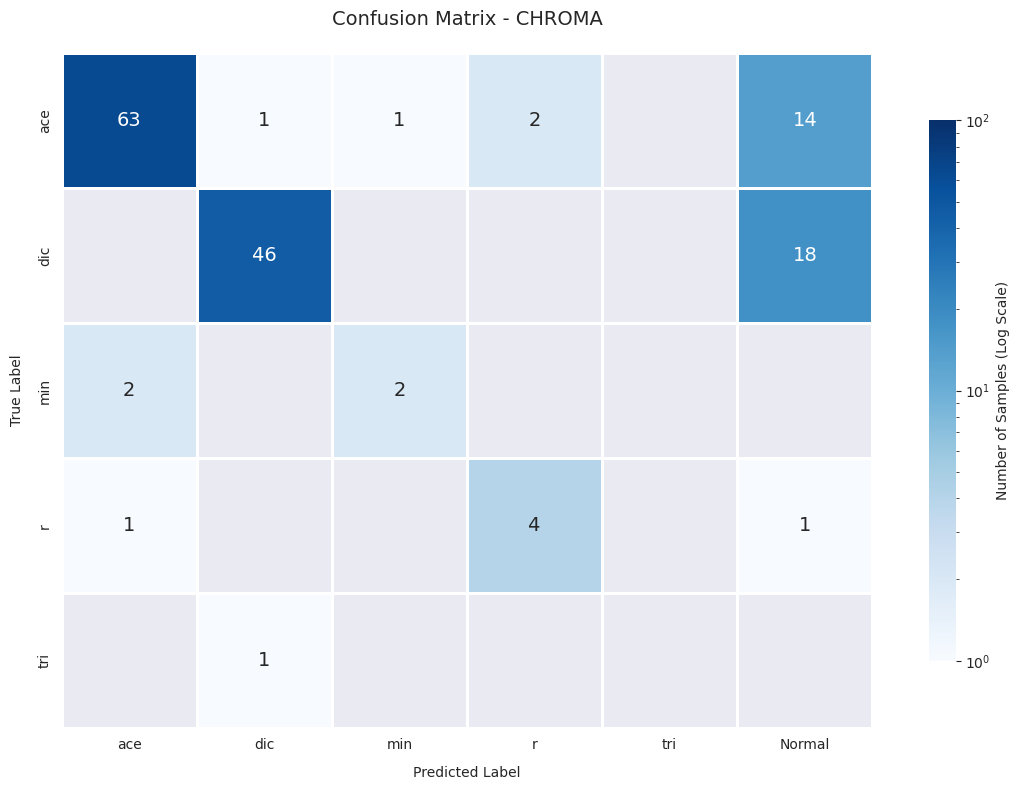


SSL-MAE 6-class confusion matrix:
[[  57    0    0    0    0   24]
 [   7   27    0    0    0   30]
 [   1    3    0    0    0    0]
 [   1    2    0    0    0    3]
 [   0    1    0    0    0    0]
 [ 130    0    0    0    0 3350]]
Accuracy: 0.944


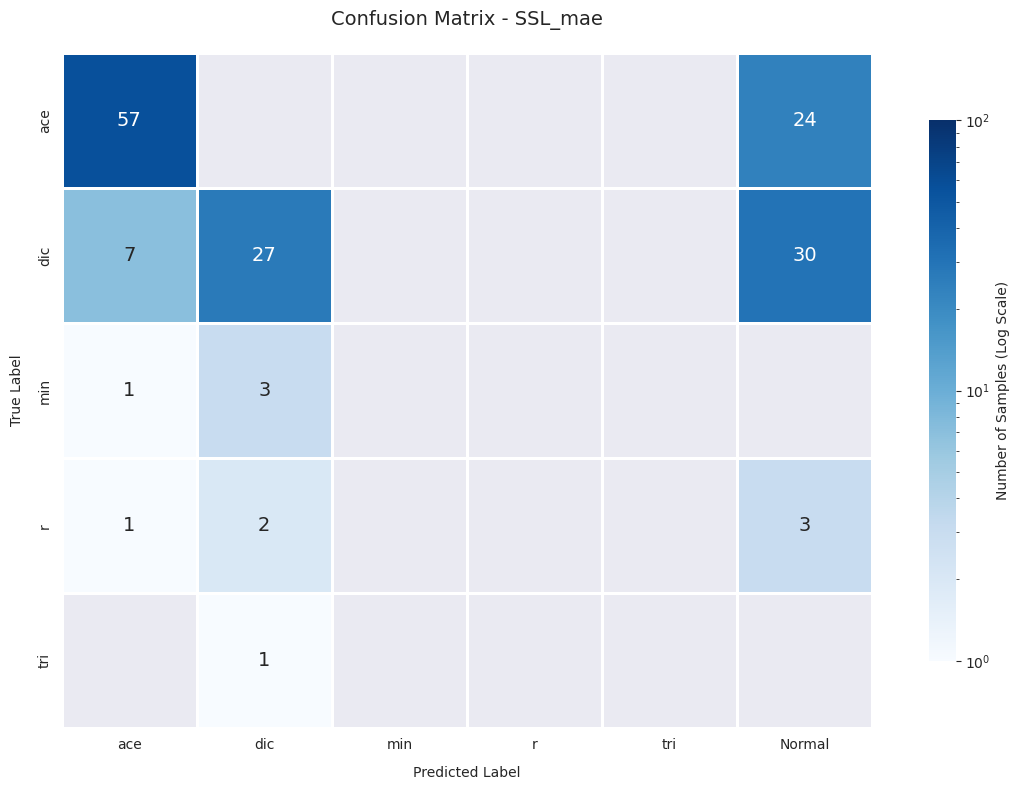

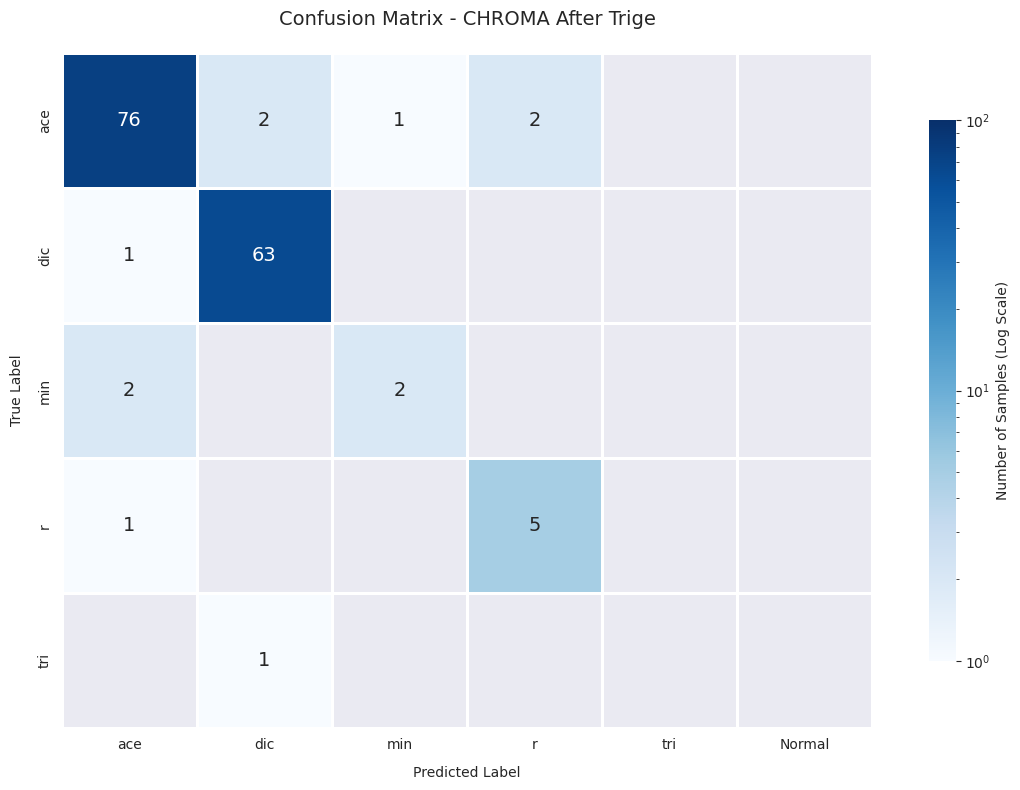

In [4]:
results_chroma = np.load('./paper_fig_unstadis_data/res_chroma.npy', allow_pickle=True).item()
results_SSL_mae = np.load('./paper_fig_unstadis_data/res_baseline_vit.npy', allow_pickle=True).item()


def plot_confusion_matrix(cm, title, save_path=None):
    class_names = ['ace', 'dic', 'min', 'r', 'tri', 'Normal']
    
    cm_display = cm[:5, :]
    
    plt.figure(figsize=(12, 8))
    with plt.style.context({'axes.grid': False}):
        sns.heatmap(cm_display,
                    annot=np.where(cm_display > 0, cm_display, ''),  
                    fmt='s',
                    # cmap="YlOrRd",  
                    # cmap="magma_r",
                    cmap="Blues",
                    # norm=LogNorm(vmin=1, vmax=cm_display.max()),
                    norm=LogNorm(vmin=1, vmax=100),
                    xticklabels=class_names,
                    yticklabels=class_names[:5],  
                    square=True,
                    linewidths=1,
                    linecolor='white',
                    cbar_kws={'label': 'Number of Samples (Log Scale)',
                             'shrink': .8},
                    annot_kws={"size": 14}
                    )
        
        plt.title(title, pad=20, fontsize=14)
        plt.xlabel('Predicted Label', labelpad=10)
        plt.ylabel('True Label', labelpad=10)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, format='svg', 
                dpi=300,
                bbox_inches='tight',
                pad_inches=0.1)
            
        plt.show()


ssl_mae_two_class = results_SSL_mae[2]['seed_0']
ssl_mae_five_class = results_SSL_mae[5]['seed_0']

ssl_mae_y2_test = ssl_mae_two_class["true_labels"][test_idx]
ssl_mae_p2_test = ssl_mae_two_class["prediction_probabilities"][test_idx]
ssl_mae_pred_2 = np.argmax(ssl_mae_p2_test, axis=1)

ssl_mae_y5_all = ssl_mae_five_class["true_labels"]
ssl_mae_p5_all = ssl_mae_five_class["prediction_probabilities"]

cm_2_chroma = confusion_matrix(y2_test, stage1_test_pred_bin, labels=[0,1])
cm_2_ssl_mae = confusion_matrix(ssl_mae_y2_test, ssl_mae_pred_2, labels=[0,1])

ssl_mae_final_pred_6 = np.full(len(test_idx), 5, dtype=int)
ssl_mae_final_true_6 = np.full(len(test_idx), 5, dtype=int)

idx_map_test = {ab_i: k for k, ab_i in enumerate(ab_indices_test)}

ssl_mae_final_true_6 = final_true_6_base  

for i, global_i in enumerate(test_idx):
    if ssl_mae_pred_2[i] == 0: 
        if ssl_mae_y2_test[i] == 0:  
            k = idx_map_test[global_i]
            c_hat = np.argmax(ssl_mae_p5_all[k])
            ssl_mae_final_pred_6[i] = c_hat
        else:  
            ssl_mae_final_pred_6[i] = 0
    else:  
        ssl_mae_final_pred_6[i] = 5

cm_6_ssl_mae = confusion_matrix(ssl_mae_final_true_6, ssl_mae_final_pred_6, labels=[0,1,2,3,4,5])

print("\n=== Binary Classification Comparison ===")
print("CHROMA 2-class confusion matrix:")
print(cm_2_chroma)
print(f"Accuracy: {(stage1_test_pred_bin == y2_test).mean():.3f}")


print("\n=== Six-class Classification Comparison ===")
print("CHROMA 6-class confusion matrix:")
print(cm_6_base)
print(f"Accuracy: {acc_6_base:.3f}")

plot_confusion_matrix(
    cm_6_base,
    title='Confusion Matrix - CHROMA',
    save_path='./svg_confusion_matrix_unsta_dist_chroma.svg'
)



print("\nSSL-MAE 6-class confusion matrix:")
print(cm_6_ssl_mae)
print(f"Accuracy: {(ssl_mae_final_pred_6 == ssl_mae_final_true_6).mean():.3f}")

plot_confusion_matrix(
    cm_6_ssl_mae,
    title='Confusion Matrix - SSL_mae',
    save_path='./svg_confusion_matrix_unsta_dist_baseline.svg'
)

# uncertainty is high, delete:
# cm_6_triage_ = cm_6_triage
# cm_6_triage_[4, :] = 0
plot_confusion_matrix(
    cm_6_triage,
    title='Confusion Matrix - CHROMA After Trige',
    save_path='./svg_confusion_matrix_unsta_dist_chroma_after_trige.svg'
)


def print_detailed_metrics(cm_2, name):
    tn, fp, fn, tp = cm_2.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    
    print(f"\n{name} detailed metrics:")
    print(f"Sensitivity: {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"PPV: {ppv:.3f}")
    print(f"NPV: {npv:.3f}")




In [230]:
# get results for all metrics:

import numpy as np

results_baseline_conv = np.load('./paper_fig_unstadis_data/res_baseline_conv.npy', allow_pickle=True).item()
results_baseline_vit = np.load('./paper_fig_unstadis_data/res_baseline_vit.npy', allow_pickle=True).item()
results_baseline_ssl_cl = np.load('./paper_fig_unstadis_data/res_baseline_ssl_cl.npy', allow_pickle=True).item()
results_baseline_ssl_mae = np.load('./paper_fig_unstadis_data/res_baseline_ssl_mae.npy', allow_pickle=True).item()
results_chroma = np.load('./paper_fig_unstadis_data/res_chroma.npy', allow_pickle=True).item()


chromosomes = [2, 5]  
metrics = ["accuracy", "sensitivity", "specificity", "G-Mean", "auc_roc", "auc_pr", "f1_score", "mcc"]


methods = {
    "conv": results_baseline_conv,
    "SL": results_baseline_vit,
    "SSL-cl": results_baseline_ssl_cl,
    "SSL-mae": results_baseline_ssl_mae,
    "CHROMA": results_chroma
}


metric_results = {method: {chrom: {metric: [] for metric in metrics} for chrom in chromosomes} for method in methods}

for method_name, method_results in methods.items():
    for chrom in chromosomes:
        if chrom not in method_results:  
            continue
        for metric in metrics:
            seeds_metric = []
            for seed_key, seed_data in method_results[chrom].items():
                if metric in seed_data:  
                    seeds_metric.append(seed_data[metric])
            metric_results[method_name][chrom][metric] = seeds_metric


for method_name, chrom_results in metric_results.items():
    # if method_name != "CHROMA":
    #     continue
    print(f"\nResults for method: {method_name}")
    for chrom, metrics_data in chrom_results.items():
        print(f"Chromosome {chrom}:")
        for metric, values in metrics_data.items():
            print(f"  {metric}: {values}")


# np.save('./metric_results_all_metrics.npy', metric_results)


Results for method: conv
Chromosome 2:
  accuracy: [0.9096310968061402, 0.9158207477098291, 0.907402822480812, 0.9227531567219609, 0.9160683337459767]
  sensitivity: [0.7559810624505796, 0.7322638059550048, 0.7332527259241755, 0.762842792122547, 0.7270024882655528]
  specificity: [0.7559810624505796, 0.7322638059550048, 0.7332527259241755, 0.762842792122547, 0.7270024882655528]
  G-Mean: [0.7369839136875099, 0.7040828924902445, 0.707972064309764, 0.7424343678225179, 0.6968421450095594]
  auc_roc: [0.8051995833662485, 0.8348957099011958, 0.8098139338242825, 0.8394043658769936, 0.8404646022230219]
  auc_pr: [0.6616628209794444, 0.6766485339415651, 0.6537585553289521, 0.7027186844594043, 0.6861535956285368]
  f1_score: [0.6571832866536211, 0.6555132732213144, 0.644717338240297, 0.6793591436487841, 0.6534722740313428]
  mcc: [0.35241422105064185, 0.33756335173664886, 0.32368923901774643, 0.3860164364463962, 0.3320669712912968]
Chromosome 5:
  accuracy: [0.8700564971751412, 0.8418079096045

### plot aucroc curve or aucpr

In [232]:
target_metric = "auc_roc"

for method_name, seeds in metric_results.items():
    # if method_name != 'CHROMA':
    #     continue
    print(f"\nResults for method: {method_name}")
    
        
    for chrom, results in seeds.items():  
            
        target_metric_results = results[target_metric]
    
        print(f"Chromosome {chrom}: {target_metric}, {target_metric_results}")
        # print(target_metric_results)

# np.save('./metric_results_with_ssl.npy', metric_results)



Results for method: conv
Chromosome 2: auc_roc, [0.8051995833662485, 0.8348957099011958, 0.8098139338242825, 0.8394043658769936, 0.8404646022230219]
Chromosome 5: auc_roc, [0.787498045319093, 0.8004779432562097, 0.8748463036514613, 0.7702418820407773, 0.8627780587708308]

Results for method: SL
Chromosome 2: auc_roc, [0.9131915491226992, 0.9134270759274051, 0.9149514171106566, 0.9157721036786068, 0.9229052011925556]
Chromosome 5: auc_roc, [0.8862353509107228, 0.9770266463209853, 0.9533983427961876, 0.9377536080467678, 0.949234423263635]

Results for method: SSL-cl
Chromosome 2: auc_roc, [0.7921936761784385, 0.7985967868877399, 0.7986348222723508, 0.7958586049206084, 0.7947098631603893]
Chromosome 5: auc_roc, [0.829108643485166, 0.8655875297881419, 0.772130717673563, 0.8432978519459893, 0.8520284372891082]

Results for method: SSL-mae
Chromosome 2: auc_roc, [0.9041098695971468, 0.9072126792417501, 0.9034852115498835, 0.8975663205446667, 0.907173180957731]
Chromosome 5: auc_roc, [0.8946

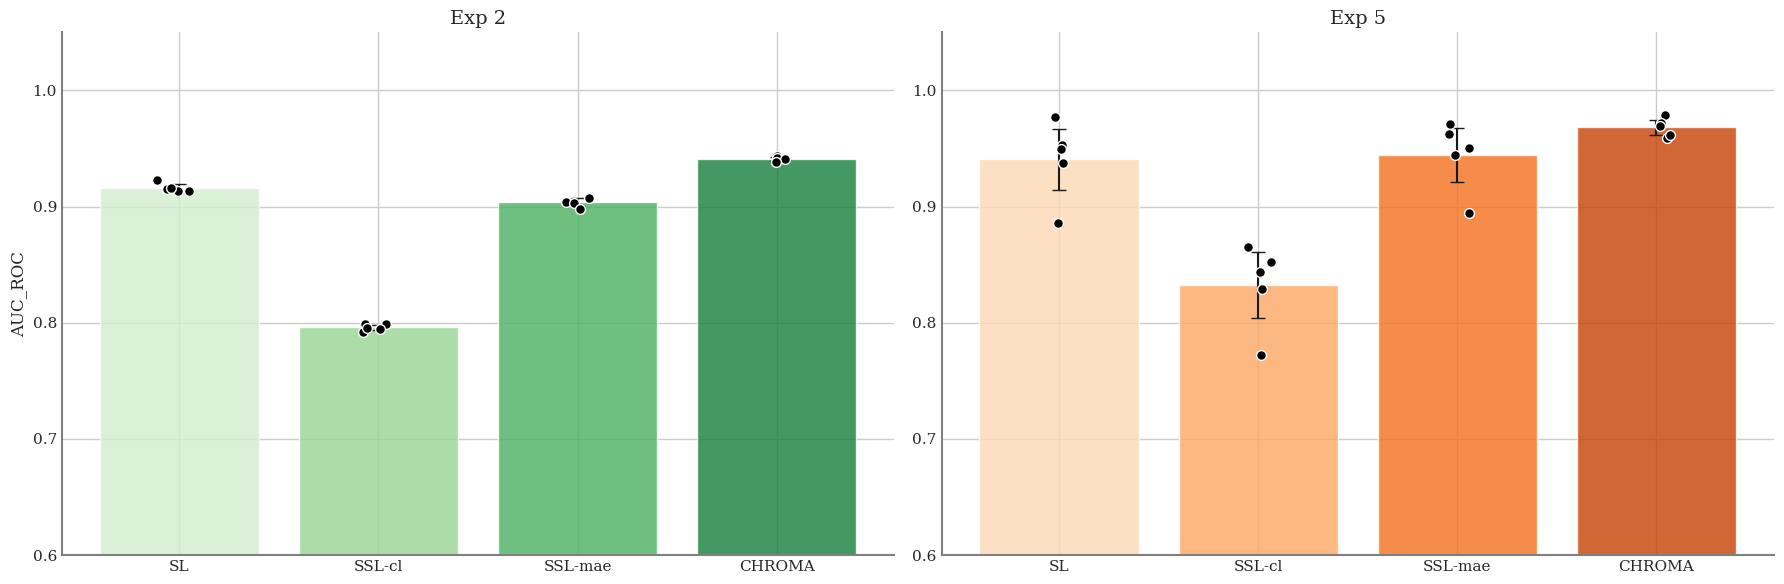

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

low_group = [2]
high_group = [5]

methods = ["SL", "SSL-cl", "SSL-mae", "CHROMA"]

group_colors = {
    "low": "Greens",
    "high": "Oranges",
}

all_chroms = low_group + high_group
all_chrom_groups = ["low"] * len(low_group) + ["high"] * len(high_group)

for chrom_index, (chrom, group) in enumerate(zip(all_chroms, all_chrom_groups)):
    auc_data = {}
    for method in methods:
        if chrom in metric_results[method] and "auc_roc" in metric_results[method][chrom]:
            auc_data[method] = metric_results[method][chrom]["auc_roc"]
    
    means = [np.mean(auc_data[method]) for method in methods]
    ci_95 = [1.96 * np.std(auc_data[method]) / np.sqrt(len(auc_data[method])) for method in methods]

    chroma_aucs = auc_data["CHROMA"]
    other_methods = {m: auc_data[m] for m in methods if m != "CHROMA"}
    if other_methods:
        second_best_method = max(other_methods, key=lambda m: np.mean(other_methods[m]))
        second_best_aucs = other_methods[second_best_method]
        _, p_value = ttest_ind(chroma_aucs, second_best_aucs, equal_var=False)

        chroma_index = methods.index("CHROMA")
        second_best_index = methods.index(second_best_method)
    else:
        p_value = 1.0
        chroma_index = None
        second_best_index = None

    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(
        methods, means, yerr=ci_95, capsize=5, 
        color=sns.color_palette(group_colors[group], len(methods)), alpha=0.8
    )

    for i, method in enumerate(methods):
        x_coords = np.random.normal(i, 0.05, size=len(auc_data[method])) 
        ax.scatter(x_coords, auc_data[method], color="black", edgecolor="white", s=50, zorder=3)

    if p_value < 0.999:  
        if p_value < 0.001:
            p_text = "P < 0.001"
        else:
            p_text = f"P = {p_value:.3f}"  
        
        ax.text(
            (chroma_index + second_best_index) / 2,  
            max(means) + 0.05,  
            p_text, ha="center", fontsize=12
        )
        
        x_start = chroma_index
        x_end = second_best_index
        y_line = max(means) + 0.03  
        ax.plot(
            [x_start, x_start, x_end, x_end], 
            [y_line, y_line + 0.01, y_line + 0.01, y_line],  
            color="black", linewidth=1
        )

    ax.set_title(f"Chromosome {chrom} (Group: {group.capitalize()})", fontsize=16)
    ax.set_ylabel("AUC_ROC", fontsize=14)
    ax.set_ylim(0.6, 1.1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()

    plt.savefig(f"./paper_fig_unstadis_data/svg_unsta_dis/exp_{chrom}_auc_roc.svg")
    # plt.show()
    plt.close()

rows = int(np.ceil(len(all_chroms) / 2))
fig, axes = plt.subplots(rows, 2, figsize=(18, 6 * rows))
axes = axes.flatten()

for chrom_index, (chrom, group) in enumerate(zip(all_chroms, all_chrom_groups)):
    ax = axes[chrom_index]

    auc_data = {}
    for method in methods:
        if chrom in metric_results[method] and "auc_roc" in metric_results[method][chrom]:
            auc_data[method] = metric_results[method][chrom]["auc_roc"]
    
    means = [np.mean(auc_data[method]) for method in methods]
    ci_95 = [1.96 * np.std(auc_data[method]) / np.sqrt(len(auc_data[method])) for method in methods]

    bars = ax.bar(
        methods, means, yerr=ci_95, capsize=5, 
        color=sns.color_palette(group_colors[group], len(methods)), alpha=0.8
    )
    
    for i, method in enumerate(methods):
        x_coords = np.random.normal(i, 0.05, size=len(auc_data[method]))  # 抖动
        ax.scatter(x_coords, auc_data[method], color="black", edgecolor="white", s=50, zorder=3)

    ax.set_title(f"Exp {chrom}", fontsize=14)
    ax.set_ylim(0.6, 1.05)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if chrom_index % 3 == 0:
        ax.set_ylabel("AUC_ROC", fontsize=12)

for i in range(len(all_chroms), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("svg_all_unsta_dis_auc_roc_overview.svg")
plt.show()
plt.close()